# コード5-1：MCMCを用いたベイズ推定の実装

『ウイルス感染の数理モデルとシミュレーション ーデータを定量的に理解するー』

MCMCを用いたベイズ推定の実装の例をまとめる。

## ライブラリ、パッケージ（モジュール）の読み込み

In [4]:
## 必要があればインストール
## !pip3 install matplotlib numpy pystan nest_asyncio
## for pystan, check https://httpstan.readthedocs.io/en/latest/installation.html for unsupported platform

In [5]:
import matplotlib.pyplot as plt
import numpy as np

## pystan
import stan
import nest_asyncio
nest_asyncio.apply()

## MCMCを用いたベイズ推定

式(3.3)

$$
F_{A,co}=\frac{1}{\left(1+\frac{\beta}{q} V ̅_{\text{GFP}} \right)^p} -\frac{1}{\left(1 + \frac{\beta}{q} \left(V ̅_{\text{GFP}}+V ̅_{\text{HSA}} \right) \right)^p} , \\
F_{B,co} = 1 - \frac{1}{\left(1 + \frac{\beta}{q} V ̅_{\text{HSA}} \right)^p} - \frac{1}{\left(1+ \frac{\beta}{q} V ̅_{\text{GFP}} \right)^p} + \frac{1}{\left(1+\frac{\beta}{q} \left(V ̅_{\text{GFP}}+V ̅_{\text{HSA}} \right)\right)^p}, \\
F_{C,co} = \frac{1}{\left(1+\frac{\beta}{q} \left(V ̅_{\text{GFP}} + V ̅_{\text{HSA}} \right)\right)^p} , \\
F_{D,co} = \frac{1}{\left(1 + \frac{\beta}{q} V ̅_{\text{HSA}} \right)^p} -\frac{1}{\left(1+\frac{\beta}{q} \left(V ̅_{\text{GFP}}+V ̅_{\text{HSA}} \right)\right)^p} .)
$$

において、各区画の割合が得られたときに、パラメータ$p, \frac{\beta}{q} V_{\text{HSA}}, \frac{\beta}{q} V_{\text{GFP}}, j_{6.25}, , j_{12.5}, j_{25}, j_{37}, j_{50}, j_{75}, j_{100}, j_{200}$を推定する。

pystanパッケージを用いて行う

参考：

- Remion et al. Virology 2016  
https://doi.org/10.1016/j.virol.2015.09.028
- Ito et al. Sci Rep 2017  
https://doi.org/10.1038/s41598-017-03954-9
- Ito et al. J Theor Biol 2018

In [6]:
## p, beta*V_HSA/q, beta*V_GFP/q, j_6.25, j_12.5, j_25, j_37, j_50, j_75, j_100, j_200
pars = np.array([1.176, #p
                 1.484*np.power(10.0, -2.0), #beta*V_HSA/q
                 2.115*np.power(10.0, -2.0), #beta*V_GFP/q
                 2.417, #j_6.25
                 4.231, #j_12.5
                 4.352, #j_25
                 11.09, #j_37
                 8.115, #j_50
                 12.79, #j_75
                 16.75, #j_100
                 26.87]) #j_200

In [7]:
## 式(3.3)
def model_coinfection(c_hsa, c_gfp, parms):
    
    p = parms[0]
    beta_vhsa_q = parms[1]
    beta_vgfp_q = parms[2]
    j625 = parms[3]
    j125 = parms[4]
    j25 = parms[5]
    j37 = parms[6]
    j50 = parms[7]
    j75 = parms[8]
    j100 = parms[9]
    j200 = parms[10]
    
    j_scale_hsa = scale_par(c_hsa, parms[3:11])
    j_scale_gfp = scale_par(c_gfp, parms[3:11])
    
    #print(j_scale_hsa, j_scale_gfp)
    
    f_a_co = 0.0; f_b_co = 0.0; f_c_co = 100.0; f_d_co = 0.0
    
    f_hsa = 1.0/np.power((1.0 + beta_vhsa_q*j_scale_hsa), p)
    f_gfp = 1.0/np.power((1.0 + beta_vgfp_q*j_scale_gfp), p)
    f_hsagfp = 1.0/np.power((1.0 + beta_vhsa_q*j_scale_hsa + beta_vgfp_q*j_scale_gfp), p)
    
    if c_hsa > 0 and c_gfp > 0:
        f_a_co = f_gfp - f_hsagfp
        f_b_co = 1 - f_gfp - f_hsa + f_hsagfp
        f_c_co = f_hsagfp
        f_d_co = f_hsa - f_hsagfp
    elif c_hsa > 0:
        f_a_co = 1 - f_hsa
        f_b_co = 0.0
        f_c_co = f_hsa
        f_d_co = 0.0
    elif c_gfp > 0:
        f_a_co = 0.0
        f_b_co = 0.0
        f_c_co = f_gfp
        f_d_co = 1 - f_gfp
    else:
        print('"At least one viral dose must be greater than 0."')
        return "At least one viral dose must be greater than 0."
     
    
    return [100.0*f_a_co, 100.0*f_b_co, 100.0*f_c_co, 100.0*f_d_co]

def scale_par(effective_virus, scales):
    if effective_virus == 3.12:
        return 1.0
    elif effective_virus == 6.25:
        return scales[0]
    elif effective_virus == 12.5:
        return scales[1]
    elif effective_virus == 25:
        return scales[2]
    elif effective_virus == 37:
        return scales[3]
    elif effective_virus == 50:
        return scales[4]
    elif effective_virus == 75:
        return scales[5]
    elif effective_virus == 100:
        return scales[6]
    elif effective_virus == 200:
        return scales[7]
    elif effective_virus == 0.0:
        return 0.0
    else:
        print('error: "Invalid dose"')
        return "Invalid dose"

In [8]:
## ノイズを加えてデータを生成

dose_hsa_single = [3.12, 6.25, 12.5, 25, 37, 50, 75, 100, 100, 200]
dose_gfp_single = [3.12, 6.25, 12.5, 25, 50, 50, 75, 100, 100, 200]

dose_hsa_co1 = [25, 50, 100]
dose_hsa_co2 = [37, 75, 100]
dose_gfp_co1 = [25, 50, 100]
dose_gfp_co2 = [50, 75, 100]

dose_hsa = dose_hsa_single + [0]*len(dose_gfp_single) + \
           [x for x in dose_hsa_co1 for i in range(len(dose_gfp_co1))] + \
           [x for x in dose_hsa_co2 for i in range(len(dose_gfp_co2))]
dose_gfp = [0]*len(dose_hsa_single) + dose_gfp_single + \
           dose_gfp_co1*len(dose_hsa_co1) + \
           dose_gfp_co2*len(dose_hsa_co2)

dose_exp = np.vstack([np.array(dose_hsa), np.array(dose_gfp)])

for i in range(dose_exp.shape[1]):
    freq_true = model_coinfection(dose_exp[:,i][0], dose_exp[:,i][1], pars)
    freq_gen = np.array(model_coinfection(dose_exp[:,i][0], dose_exp[:,i][1], pars))*np.array(np.random.uniform(0.6, 1.4, 4))
    freq_gen = 100*freq_gen/freq_gen.sum()
    #print("f:", freq_gen)
    if i == 0:
        data_true = freq_true
        data_gen = freq_gen
    else:
        data_true = np.vstack([data_true, freq_true])
        data_gen = np.vstack([data_gen, freq_gen])

In [27]:
data_true

array([[ 1.71744233,  0.        , 98.28255767,  0.        ],
       [ 4.0595243 ,  0.        , 95.9404757 ,  0.        ],
       [ 6.91092183,  0.        , 93.08907817,  0.        ],
       [ 7.0955428 ,  0.        , 92.9044572 ,  0.        ],
       [16.40374914,  0.        , 83.59625086,  0.        ],
       [12.51670968,  0.        , 87.48329032,  0.        ],
       [18.48433566,  0.        , 81.51566434,  0.        ],
       [22.9773539 ,  0.        , 77.0226461 ,  0.        ],
       [22.9773539 ,  0.        , 77.0226461 ,  0.        ],
       [32.60784394,  0.        , 67.39215606,  0.        ],
       [ 0.        ,  0.        , 97.56874054,  2.43125946],
       [ 0.        ,  0.        , 94.30552004,  5.69447996],
       [ 0.        ,  0.        , 90.41229619,  9.58770381],
       [ 0.        ,  0.        , 90.16318084,  9.83681916],
       [ 0.        ,  0.        , 83.00445659, 16.99554341],
       [ 0.        ,  0.        , 83.00445659, 16.99554341],
       [ 0.        ,  0.

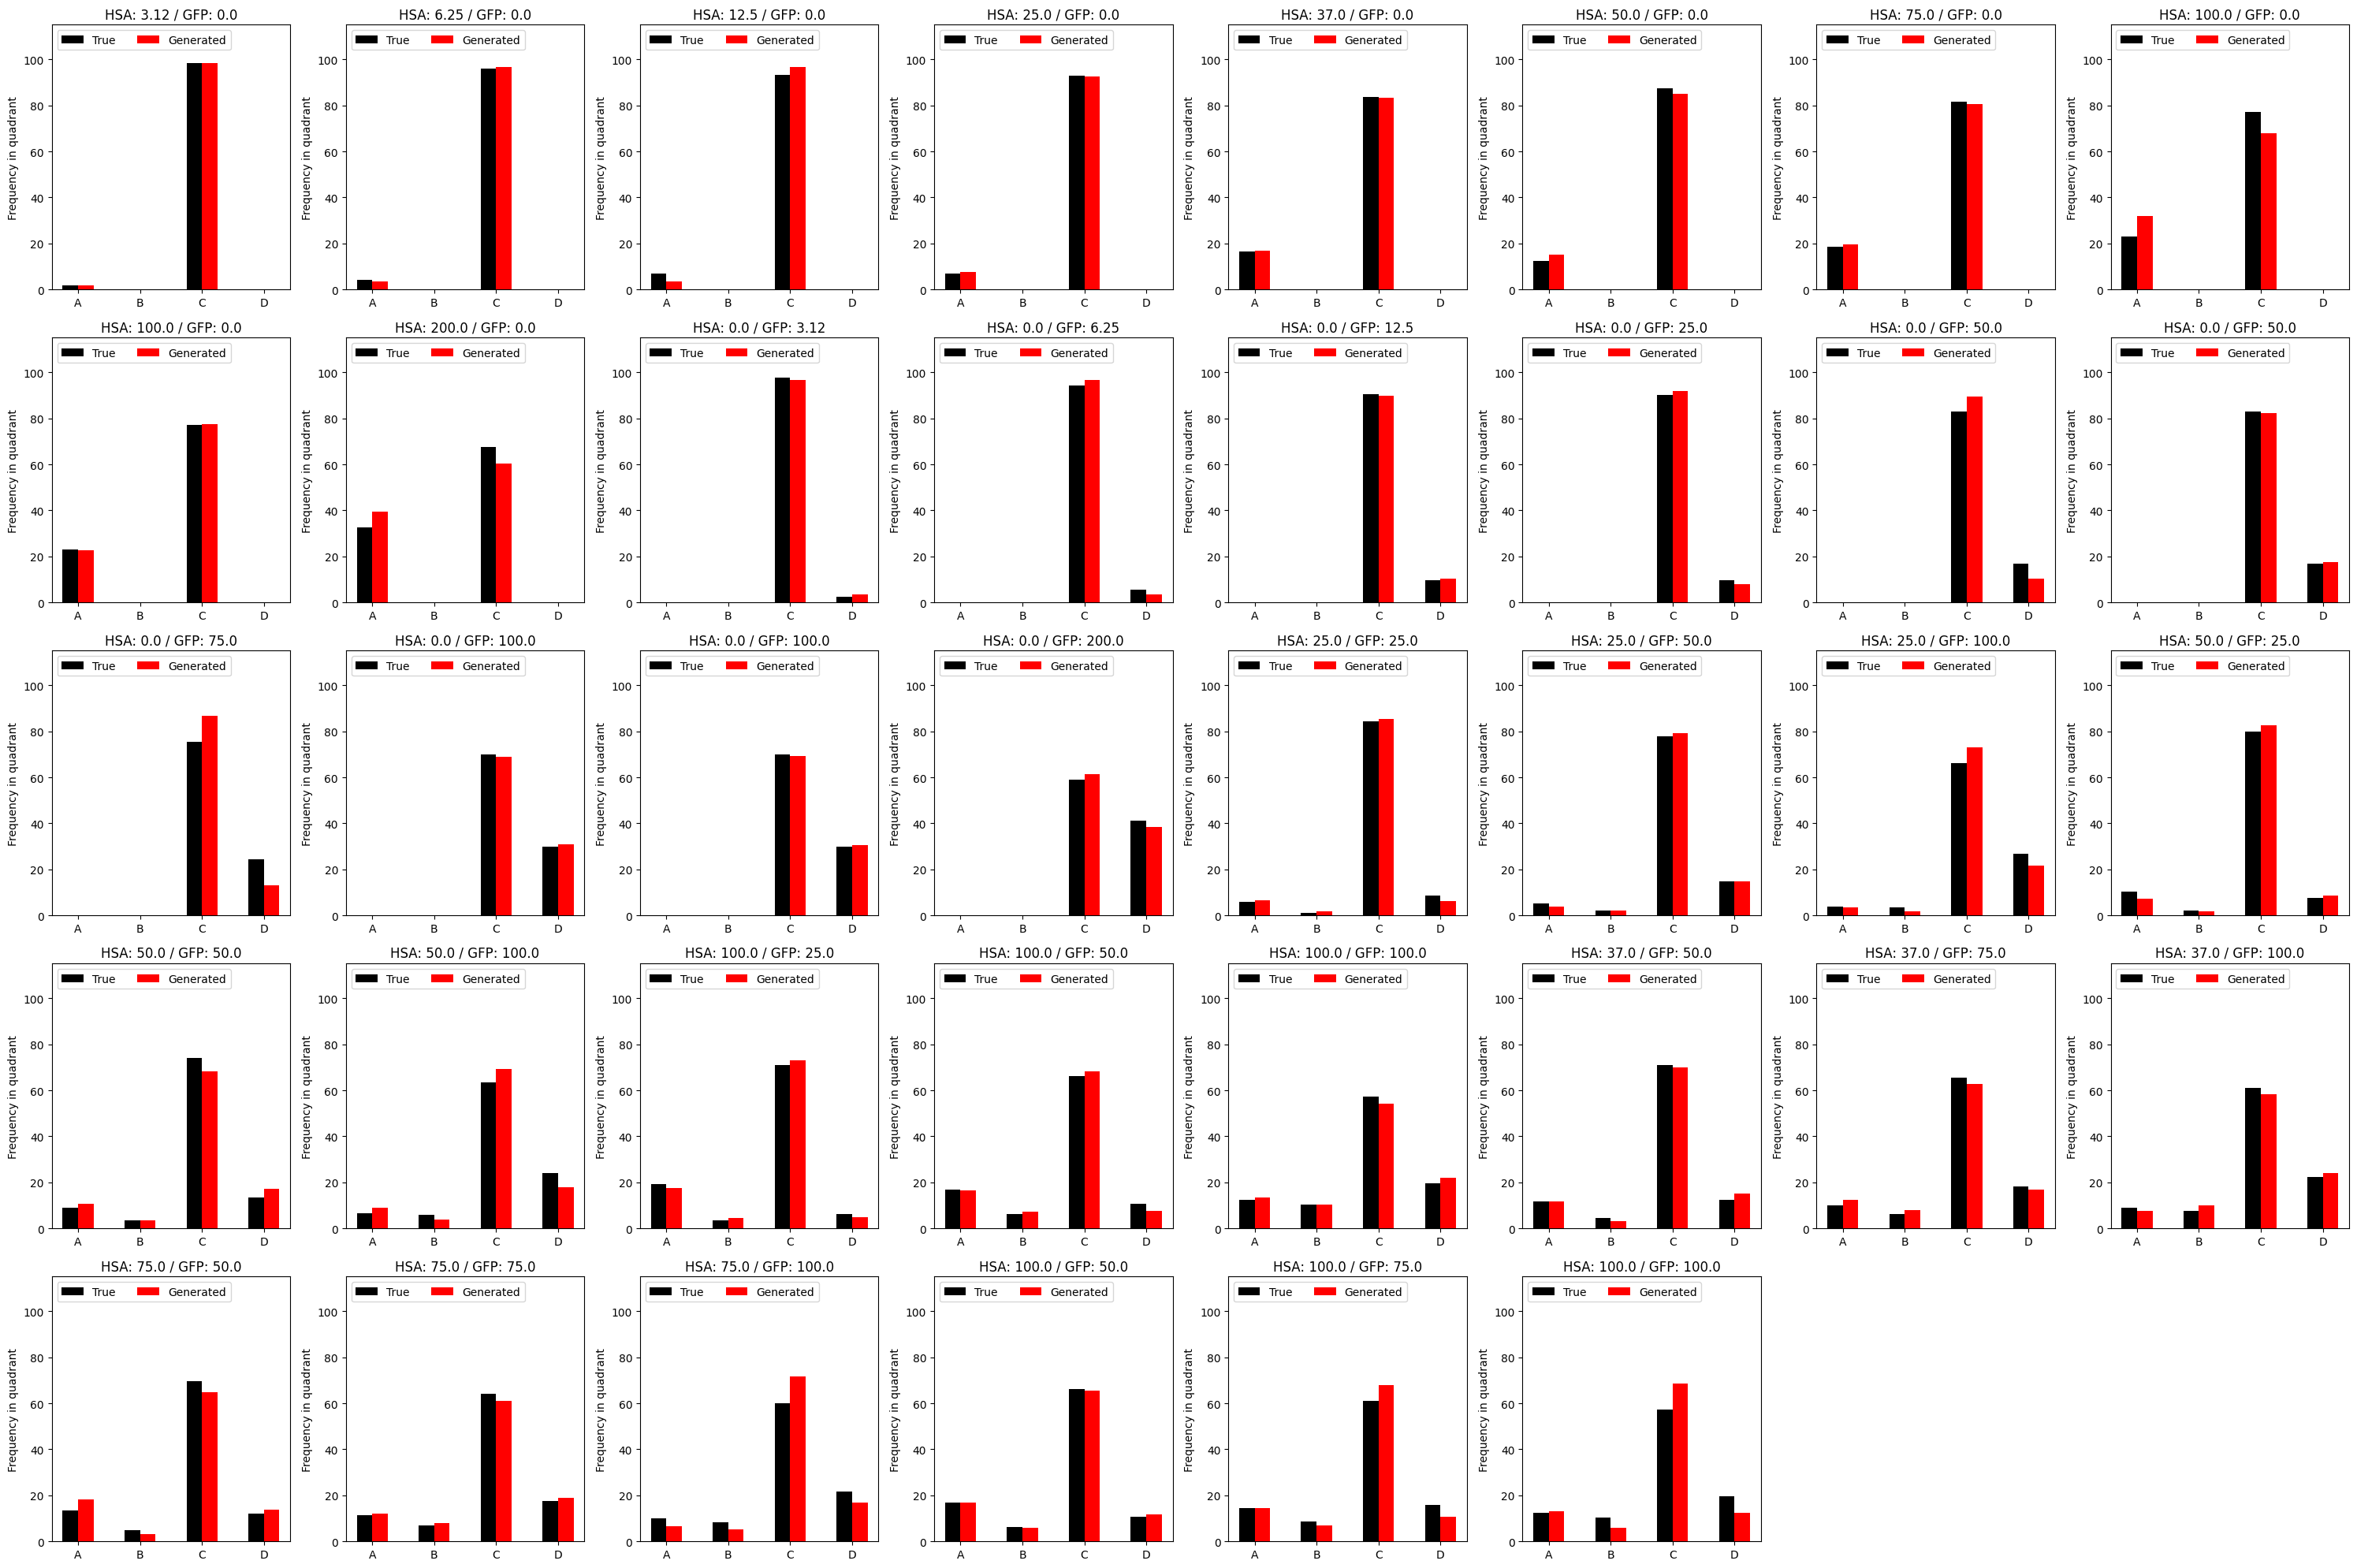

In [9]:
## データのプロット

fig = plt.figure(figsize = (30, 20))

for i in range(data_gen.shape[0]):
    ax = fig.add_subplot(5, 8, i+1)

    x = np.arange(data_gen.shape[1])
    width = 0.25

    offset = 0
    ax.bar(x + offset, data_true[i,], width, label = "True", color = "black")
    offset = width
    ax.bar(x + offset, data_gen[i,], width, label = "Generated", color = "red")

    ax.set_ylabel('Frequency in quadrant')
    ax.set_title("HSA: " + str(dose_exp[:,i][0]) + " / " + "GFP: " + str(dose_exp[:,i][1]))
    ax.set_xticks((x + x + width*(2 - 1))/2, ["A", "B", "C", "D"])
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 115)

fig.tight_layout()
plt.show()


In [10]:
model_stan_coinfection = """
functions {
  
  real scale_par(int effective_virus, array[] real scales) {
    if (effective_virus == 1) {
        return 1.0;
    } else if (effective_virus > 1 && effective_virus < 10) {
        return scales[effective_virus + 2];
    }  else if (effective_virus == 0) {
        return 0.0;
    } else {
        return 1000000.0;
    }
  }
  array[] real model_coinfection(int c_hsa, int c_gfp, array[] real parms, int expt_type) {
    real p = parms[1];
    real beta_vhsa_q = parms[2];
    real beta_vgfp_q = parms[3];
    
    real j_scale_hsa = scale_par(c_hsa, parms);
    real j_scale_gfp = scale_par(c_gfp, parms);
    
    real f_a_co = 0.0; real f_b_co = 0.0; real f_c_co = 100.0; real f_d_co = 0.0;
    
    real f_hsa = 1.0/pow((1.0 + beta_vhsa_q*j_scale_hsa), p);
    real f_gfp = 1.0/pow((1.0 + beta_vgfp_q*j_scale_gfp), p);
    real f_hsagfp = 1.0/pow((1.0 + beta_vhsa_q*j_scale_hsa + beta_vgfp_q*j_scale_gfp), p);
    
    if (c_hsa > 0 && c_gfp > 0) {
        f_a_co = f_gfp - f_hsagfp;
        f_b_co = 1.0 - f_gfp - f_hsa + f_hsagfp;
        f_c_co = f_hsagfp;
        f_d_co = f_hsa - f_hsagfp;
    } else if (c_hsa > 0) {
        f_a_co = 1.0 - f_hsa;
        f_b_co = 0.0;
        f_c_co = f_hsa;
        f_d_co = 0.0;
    } else if (c_gfp > 0) {
        f_a_co = 0.0;
        f_b_co = 0.0;
        f_c_co = f_gfp;
        f_d_co = 1.0 - f_gfp;
    } else {
    
    }
    
    if (expt_type == 1) {
      return {100.0*f_a_co, 100.0*f_c_co};
    } else if (expt_type == 2) {
      return {100.0*f_c_co, 100.0*f_d_co};
    } else {
      return {100.0*f_a_co, 100.0*f_b_co, 100.0*f_c_co, 100.0*f_d_co};
    }
    
  }
  
  
}
data {
  int<lower=0> num_expt_HSA_single;         // number of experiments
  int<lower=0> num_expt_GFP_single;         // number of experiments
  int<lower=0> num_expt_co;         // number of experiments
  int<lower=0> num_quad_HSA_single;      // number of quadorants
  int<lower=0> num_quad_GFP_single;      // number of quadorants
  int<lower=0> num_quad_co;      // number of quadorants
  array[num_expt_HSA_single, num_quad_HSA_single] real freqs_HSA_single;   // frequency
  array[num_expt_GFP_single, num_quad_GFP_single] real freqs_GFP_single;   // frequency
  array[num_expt_co, num_quad_co] real freqs_co;   // frequency
  array[num_expt_HSA_single, 2] int conc_HSA_single;  //effective virus titier, HSA, GFP
  array[num_expt_GFP_single, 2] int conc_GFP_single;  //effective virus titier, HSA, GFP
  array[num_expt_co, 2] int conc_co;  //effective virus titier, HSA, GFP
}
parameters {
  // model parameters
  real<lower=log(0.01), upper=log(100.0)> p;
  real<lower=log(0.0001), upper=log(1.0)> beta_vhsa_q;
  real<lower=log(0.0001), upper=log(1.0)> beta_vgfp_q;
  real<lower=log(0.01), upper=log(100.0)> j625;
  real<lower=log(0.01), upper=log(100.0)> j125;
  real<lower=log(0.01), upper=log(100.0)> j25;
  real<lower=log(0.01), upper=log(100.0)> j37;
  real<lower=log(0.01), upper=log(100.0)> j50;
  real<lower=log(0.01), upper=log(100.0)> j75;
  real<lower=log(0.01), upper=log(100.0)> j100;
  real<lower=log(0.01), upper=log(100.0)> j200;
  
  // standard deviation of error model
  real<lower=0, upper=1000.0> sigma;
}
transformed parameters{
  array[num_expt_HSA_single, num_quad_HSA_single] real y_HSA_single;
  array[num_expt_GFP_single, num_quad_GFP_single] real y_GFP_single;
  array[num_expt_co, num_quad_co] real y_co;
  {
    array[11] real parms;
    parms[1] = exp(p); parms[2] = exp(beta_vhsa_q); parms[3] = exp(beta_vgfp_q);
    parms[4] = exp(j625); parms[5] = exp(j125); parms[6] = exp(j25); parms[7] = exp(j37);
    parms[8] = exp(j50); parms[9] = exp(j75); parms[10] = exp(j100); parms[11] = exp(j200);
    
    // HSA single
    for (i in 1:num_expt_HSA_single) {
      y_HSA_single[i,] = model_coinfection(conc_HSA_single[i, 1], conc_HSA_single[i, 2], parms, 1);
    }
    // GFP single
    for (i in 1:num_expt_GFP_single) {
      y_GFP_single[i,] = model_coinfection(conc_GFP_single[i, 1], conc_GFP_single[i, 2], parms, 2);
    }
    // coinfection
    for (i in 1:num_expt_co) {
      y_co[i,] = model_coinfection(conc_co[i, 1], conc_co[i, 2], parms, 3);
    }
    
  }
}
model {
  // priors
  p ~ uniform(log(0.01), log(100.0)); //1.176
  beta_vhsa_q ~ uniform(log(0.0001), log(1.0)); //1.484*np.power(10.0, -2.0)
  beta_vgfp_q ~ uniform(log(0.0001), log(1.0)); //2.115*np.power(10.0, -2.0)
  j625 ~ uniform(log(0.01), log(100.0)); //2.417
  j125 ~ uniform(log(0.01), log(100.0)); //4.231
  j25 ~ uniform(log(0.01), log(100.0)); //4.352
  j37 ~ uniform(log(0.01), log(100.0)); //11.09
  j50 ~ uniform(log(0.01), log(100.0)); //8.115
  j75 ~ uniform(log(0.01), log(100.0)); //12.79
  j100 ~ uniform(log(0.01), log(100.0)); //16.75
  j200 ~ uniform(log(0.01), log(100.0)); //26.87
  
  // HSA single
  for (i in 1:num_expt_HSA_single) {
    for (j in 1:num_quad_HSA_single) {
      freqs_HSA_single[i, j] ~ lognormal(log(y_HSA_single[i, j]), sigma);
    }
  }
  // GFP signle
  for (i in 1:num_expt_GFP_single) {
    for (j in 1:num_quad_GFP_single) {
      freqs_GFP_single[i, j] ~ lognormal(log(y_GFP_single[i, j]), sigma);
    }
  }
  // coinfection
  for (i in 1:num_expt_co) {
    for (j in 1:num_quad_co) {
      freqs_co[i, j] ~ lognormal(log(y_co[i, j]), sigma);
    }
  }
  sigma ~ cauchy(0,5);
}
"""

In [29]:
freqs_HSA_single = data_gen[0:10, [0, 2]]
freqs_GFP_single = data_gen[10:20, [2, 3]]
freqs_co = data_gen[20:38, ]
## 0: 0, 1: 3.12, 2: 6.25, 3: 12.5, 4: 25, 5: 37, 6: 50, 7: 75, 8: 100, 9: 200
d_hsa_single = [1, 2, 3, 4, 5, 6, 7, 8, 8, 9]
d_gfp_single = [1, 2, 3, 4, 6, 6, 7, 8, 8, 9]
d_hsa_co1 = [4, 6, 8]
d_hsa_co2 = [5, 7, 8]
d_gfp_co1 = [4, 6, 8]
d_gfp_co2 = [6, 7, 8]

conc_HSA_single = np.array([d_hsa_single, [0]*len(d_hsa_single)]).T
conc_GFP_single = np.array([[0]*len(d_gfp_single), d_gfp_single]).T
conc_co = np.array([[x for x in d_hsa_co1 for i in range(len(d_gfp_co1))] + \
                    [x for x in d_hsa_co2 for i in range(len(d_gfp_co2))], \
                    d_gfp_co1*len(d_hsa_co1) + \
                    d_gfp_co2*len(d_hsa_co2)]).T

data_stan = {"num_expt_HSA_single": 10,
             "num_expt_GFP_single": 10,
             "num_expt_co": 18,
             "num_quad_HSA_single": 2,
             "num_quad_GFP_single": 2,
             "num_quad_co": 4,
             "freqs_HSA_single": freqs_HSA_single,
             "freqs_GFP_single": freqs_GFP_single,
             "freqs_co": freqs_co,
             "conc_HSA_single": conc_HSA_single,
             "conc_GFP_single": conc_GFP_single,
             "conc_co": conc_co}

In [12]:
posterior = stan.build(model_stan_coinfection, data=data_stan, random_seed=1)

Building...



Building: 20.2s, done.Messages from stanc:
    in its declaration. These hard constraints are not recommended, for two
    reasons: (a) Except when there are logical or physical constraints, it is
    very unusual for you to be sure that a parameter will fall inside a
    specified range, and (b) The infinite gradient induced by a hard
    constraint can cause difficulties for Stan's sampling algorithm. As a
    consequence, we recommend soft constraints rather than hard constraints;
    for example, instead of constraining an elasticity parameter to fall
    between 0, and 1, leave it unconstrained and give it a normal(0.5,0.5)
    prior distribution.


In [13]:
num_sample = 10000

fit = posterior.sample(num_chains=4, num_samples=num_sample, num_warmup = 1000)

Sampling:   0%
Sampling:   0% (100/44000)
Sampling:   1% (300/44000)
Sampling:   1% (500/44000)
Sampling:   2% (700/44000)
Sampling:   2% (1000/44000)
Sampling:   3% (1400/44000)
Sampling:   4% (1900/44000)
Sampling:   5% (2400/44000)
Sampling:  30% (13000/44000)
Sampling:  53% (23400/44000)
Sampling:  77% (33700/44000)
Sampling: 100% (44000/44000)
Sampling: 100% (44000/44000), done.
Messages received during sampling:
  Gradient evaluation took 8.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.83 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lognormal_lpdf: Scale parameter is 0, but must be positive finite! (in '/tmp/httpstan_2yg2qeva/model_b5ahfckr.stan', line 133, column 6 to column 73)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

In [14]:
df_fit = fit.to_frame()

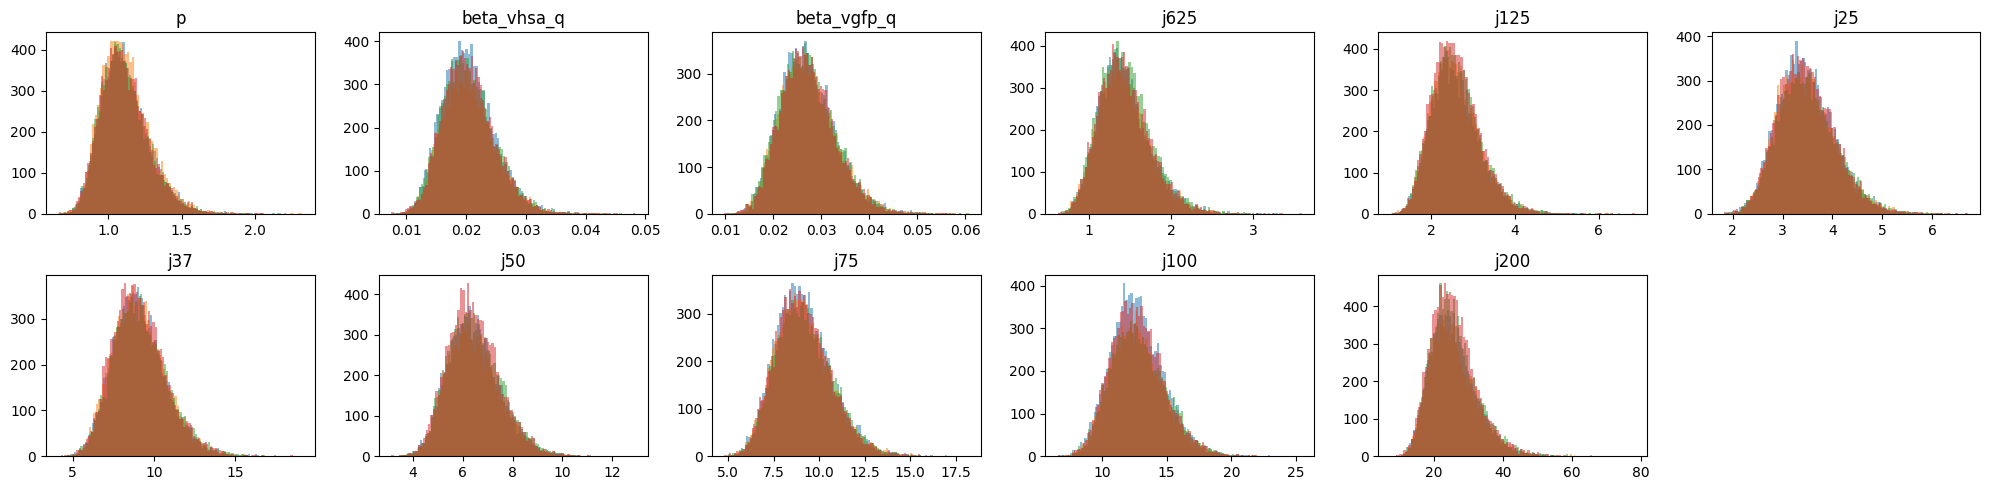

In [15]:
fig = plt.figure(figsize = (20, 5))

for i in range(11):
    ax = fig.add_subplot(2, 6, i + 1)
    for j in range(4):
        ax.hist(np.exp(df_fit[fit.param_names[i]][(j*num_sample):(j+1)*num_sample]), bins = 100, alpha = 0.5)
        ax.set_title(fit.param_names[i])
    
fig.tight_layout()
plt.show()

In [16]:
mean_HSA_single = []
mean_GFP_single = []
mean_co = []
ci_HSA_single = []
ci_GFP_single = []
ci_co = []

mean_all = df_fit.mean(axis='rows')
ci_low_all = mean_all - df_fit.quantile(q=0.025)
ci_up_all = df_fit.quantile(q=0.975) - mean_all

for i in range(10):
    mean_HSA_single.append([mean_all[i+19], mean_all[i+29]])
    mean_GFP_single.append([mean_all[i+39], mean_all[i+49]])
    ci_HSA_single.append([[ci_low_all[i+19], ci_low_all[i+29]], [ci_up_all[i+19], ci_up_all[i+29]]])
    ci_GFP_single.append([[ci_low_all[i+39], ci_low_all[i+49]], [ci_up_all[i+39], ci_up_all[i+49]]])

for i in range(18):
    mean_temp = []
    ci_low_temp = []
    ci_up_temp = []
    for j in range(4):
        mean_temp.append(mean_all[i+59+j*18])
        ci_low_temp.append(ci_low_all[i+59+j*18])
        ci_up_temp.append(ci_up_all[i+59+j*18])
    mean_co.append(mean_temp)
    ci_co.append([ci_low_temp, ci_up_temp])

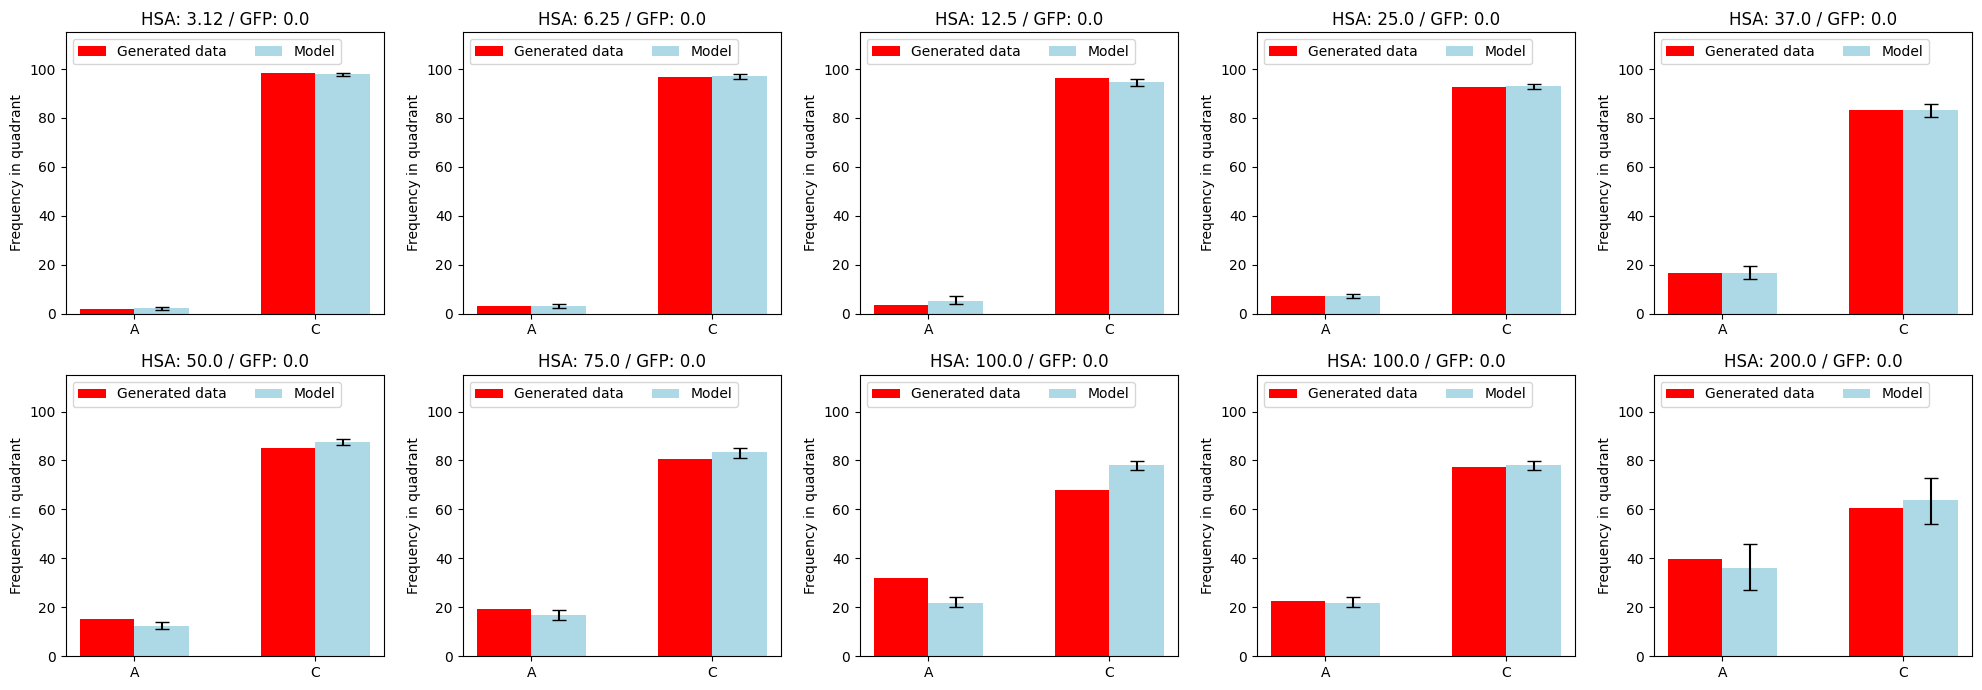

In [17]:
fig = plt.figure(figsize = (20, 7))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    
    x = np.arange(2)
    width = 0.3
    
    offset = 0
    ax.bar(x + offset, data_gen[i,[0,2]], width, label = "Generated data", color = "red")
    offset = width
    ax.bar(x + offset, mean_HSA_single[i], width, label = "Model", color = "lightblue")
    ax.errorbar(x + offset, mean_HSA_single[i], yerr = ci_HSA_single[i], color = "black", capsize=5, ls='none')

    ax.set_ylabel('Frequency in quadrant')
    ax.set_title("HSA: " + str(dose_exp[0,i]) + " / " + "GFP: " + str(dose_exp[1,i]))
    ax.set_xticks((x + x + width*(2 - 1))/2, ["A", "C"])
    ax.legend(loc='upper left', ncols=3)
    
    ax.set_ylim(0, 115)

fig.tight_layout()
plt.show()

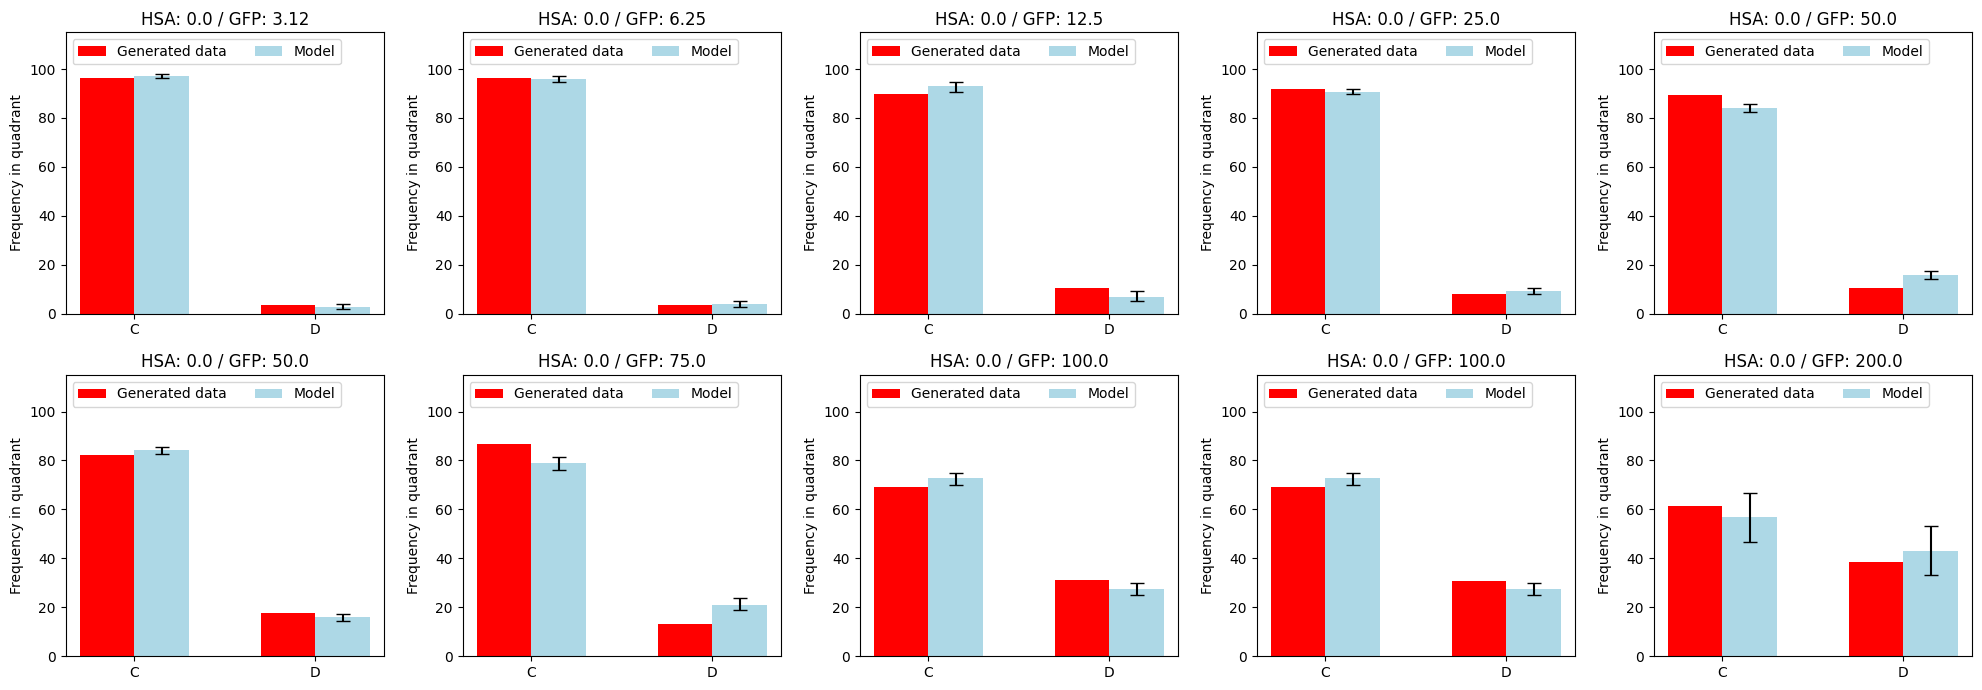

In [18]:
fig = plt.figure(figsize = (20, 7))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    
    x = np.arange(2)
    width = 0.3
    
    offset = 0
    ax.bar(x + offset, data_gen[i+10,[2,3]], width, label = "Generated data", color = "red")
    offset = width
    ax.bar(x + offset, mean_GFP_single[i], width, label = "Model", color = "lightblue")
    ax.errorbar(x + offset, mean_GFP_single[i], yerr = ci_GFP_single[i], color = "black", capsize=5, ls='none')

    ax.set_ylabel('Frequency in quadrant')
    ax.set_title("HSA: " + str(dose_exp[0,i+10]) + " / " + "GFP: " + str(dose_exp[1,i+10]))
    ax.set_xticks((x + x + width*(2 - 1))/2, ["C", "D"])
    ax.legend(loc='upper left', ncols=3)
    
    ax.set_ylim(0, 115)

fig.tight_layout()
plt.show()

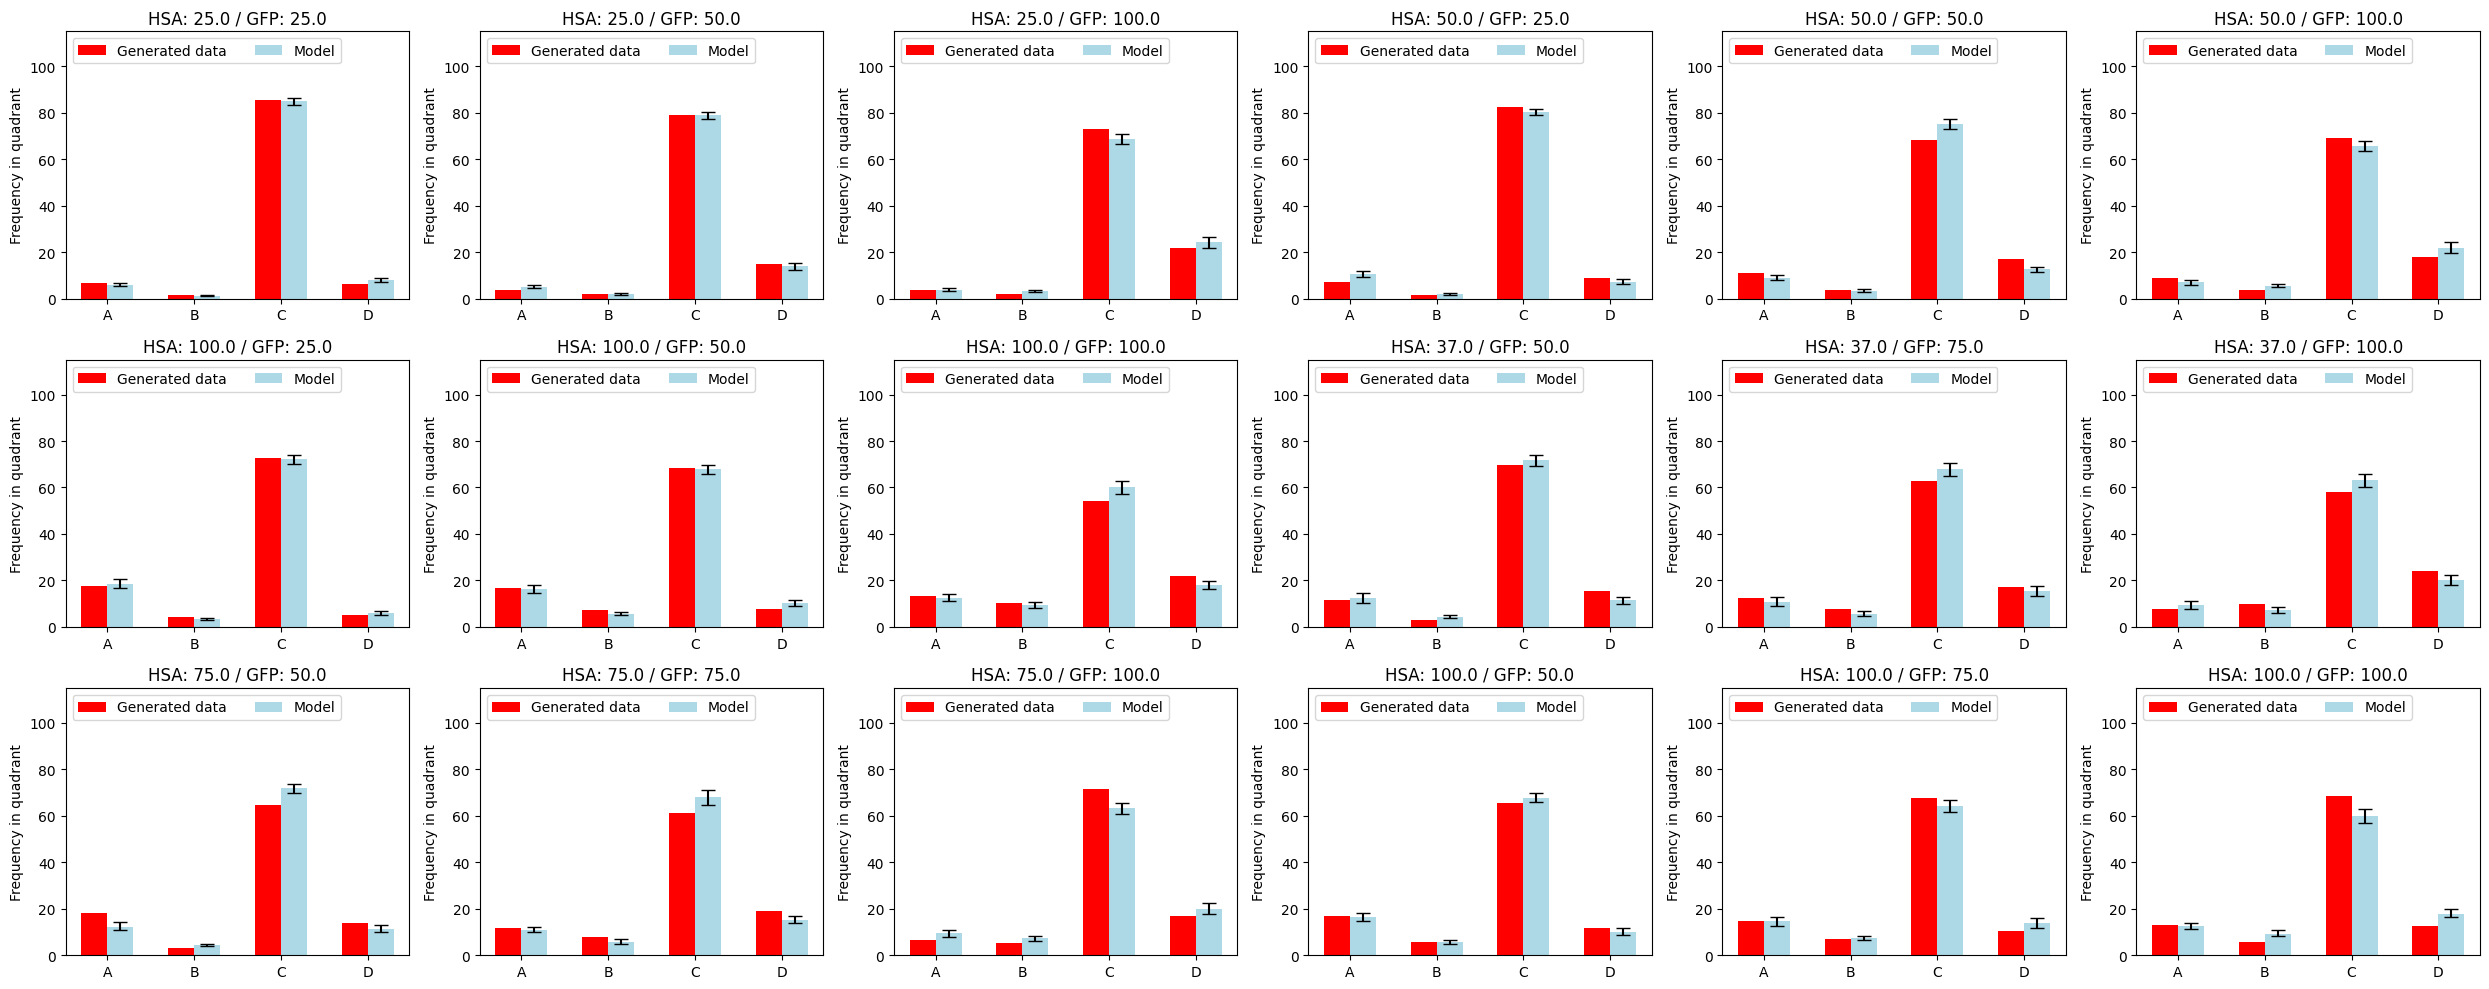

In [19]:
fig = plt.figure(figsize = (25, 10))

for i in range(18):
    ax = fig.add_subplot(3, 6, i + 1)
    
    x = np.arange(4)
    width = 0.3
    
    offset = 0
    ax.bar(x + offset, data_gen[i+20,], width, label = "Generated data", color = "red")
    offset = width
    ax.bar(x + offset, mean_co[i], width, label = "Model", color = "lightblue")
    ax.errorbar(x + offset, mean_co[i], yerr = ci_co[i], color = "black", capsize=5, ls='none')

    ax.set_ylabel('Frequency in quadrant')
    ax.set_title("HSA: " + str(dose_exp[0,i+20]) + " / " + "GFP: " + str(dose_exp[1,i+20]))
    ax.set_xticks((x + x + width*(2 - 1))/2, ["A", "B", "C", "D"])
    ax.legend(loc='upper left', ncols=3)
    
    ax.set_ylim(0, 115)

fig.tight_layout()
plt.show()

### 常微分方程式

ウイルスダイナミクスのような常微分方程式系によるシミュレーションと併せたベイズ推定手法を紹介する。

式（2.12）

$$
\begin{align}
\frac{d T \left( t \right)}{dt} &= L(t) - \beta T(t) V(t) \\
\frac{d I \left( t \right)}{dt} &= \beta T(t) V(t) - \delta I(t) \\
\frac{d V \left( t \right)}{dt} &= p I(t) - c V(t)
\end{align}
$$

について
$L(t) = \lambda - d T(t), \lambda = 0, d = 0.057, \beta = 8.61 \times 10^{-11}, \delta = 0.057 + 1.75, p = 3.26 \times 10^4, c = 1.93 + 0.039, T(0) = 6.46 \times 10^6, I(0) = 10^{-1}, V(0) = 5.0 \times 10^4$

In [4]:
## 擬似データの生成

In [5]:
## 推定